# CNN for Tomato Leaf Disease Classification (PlantVillage)

This notebook trains (or loads) a CNN model to classify **tomato leaf** images into disease categories using the **PlantVillage – Tomatoes** subset.

**Workflow**
1. Import libraries and set hyperparameters  
2. Load and explore the Tomato subset  
3. Split into train/validation/test  
4. Build, compile, and train the CNN (or reload a saved model)  
5. Evaluate on the test set (accuracy, classification report, confusion matrix)  
6. Do basic error analysis


## 1. Imports
We import the main libraries used in this notebook: TensorFlow/Keras for the CNN, NumPy for arrays, and Matplotlib for plots.


In [54]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
import pandas as pd


## 2. Basic configuration
Set the key hyperparameters: image size, batch size, number of channels (RGB), and training epochs.


In [37]:
image_size = (256) # 256x256 pixels
batch_size = 16 # images per batch
channels = 3 # RGB
epochs = 40 # number of training epochs


## 3. Load the dataset and exploratory data analysis
Loads images from your **Tomatoes** directory (PlantVillage subset). Each subfolder name becomes a class label automatically.

Expected layout (from the notebook folder):

- `../data/plant_village_dataset/Tomatoes/`
  - `Tomato___bacterial_spot/`
  - `Tomato___early_blight/`
  - `...`


In [38]:
# Load Tomato images from a folder structure into a tf.data.Dataset.
# Expected folder layout:
#   ../data/plant_village_dataset/Tomatoes/
#       Tomato___bacterial_spot/  (images...)
#       Tomato___early_blight/    (images...)
#       ...
# Each subfolder name becomes the class label automatically.

TOMATO_DIR = "../data/clean_data/Tomatoes"  # PlantVillage (Tomatoes subset)

dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TOMATO_DIR,                 # root folder containing one subfolder per class
    image_size=(image_size, image_size),  # resize every image to this fixed size (H, W)
    batch_size=batch_size,                # how many images per batch returned by the dataset
    label_mode="int",                     # integer labels (0..n_classes-1)
    shuffle=True,
    seed=12,
)

# Result:
# - dataset yields batches of (images, labels)
# - images shape: (batch_size, image_size, image_size, 3)
# - labels are integer class IDs (e.g., 0..num_classes-1)


Found 16694 files belonging to 10 classes.


### Class names
Keras assigns an integer label to each class based on folder order. `class_names` stores the mapping.


In [39]:
# Get the list of class (label) names inferred from the subfolder names
# inside the Tomatoes directory.
# Example: ["Tomato___healthy", "Tomato___late_blight", ...]
class_names = dataset.class_names

# Display / print the class names (in notebooks, the last line shows the value)
class_names


['Tomato___Leaf_mold',
 'Tomato___bacterial_spot',
 'Tomato___early_blight',
 'Tomato___healthy',
 'Tomato___late_blight',
 'Tomato___mosaic_virus',
 'Tomato___septoria_leaf_spot',
 'Tomato___spider_mites_two-spotted_spider_mite',
 'Tomato___target_spot',
 'Tomato___yellow_leaf_curl_virus']

In [23]:
from pathlib import Path

TOMATO_DIR = Path(TOMATO_DIR)  # convert str -> Path
# or set it directly:
# TOMATO_DIR = Path("../data/plant_village_dataset/Tomatoes")

counts = {}
for class_dir in sorted([p for p in TOMATO_DIR.iterdir() if p.is_dir()]):
    n = sum(1 for f in class_dir.rglob("*") if f.suffix.lower() in [".jpg", ".jpeg", ".png"])
    counts[class_dir.name] = n

for k, v in counts.items():
    print(f"{k}: {v}")

print("\nTotal images:", sum(counts.values()))
print("Num classes:", len(counts))


Tomato___bacterial_spot: 2338
Tomato___early_blight: 1079
Tomato___healthy: 1693
Tomato___late_blight: 2107
Tomato___Leaf_mold: 1104
Tomato___mosaic_virus: 414
Tomato___septoria_leaf_spot: 1911
Tomato___spider_mites_two-spotted_spider_mite: 1665
Tomato___target_spot: 1404
Tomato___yellow_leaf_curl_virus: 2979

Total images: 16694
Num classes: 10


### Inspect one batch
Checks the tensor shapes coming from the dataset and prints the label ids in that batch.


In [40]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)   # image batch shape
    print(label_batch.numpy()) # labels as numpy


(16, 256, 256, 3)
[6 4 1 1 3 7 1 3 8 2 3 9 1 8 6 1]


### Inspect one image shape
Shows the shape of a single image tensor (height, width, channels).


In [28]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(256, 256, 3)


### Inspect raw pixel values
Prints raw pixel values for one image (before rescaling).


In [41]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())  # pixel values (array) of the first image in the batch



[[[168. 157. 165.]
  [165. 154. 162.]
  [172. 161. 169.]
  ...
  [139. 126. 135.]
  [142. 129. 138.]
  [132. 119. 128.]]

 [[174. 163. 171.]
  [166. 155. 163.]
  [167. 156. 164.]
  ...
  [134. 121. 130.]
  [133. 120. 129.]
  [123. 110. 119.]]

 [[181. 170. 178.]
  [168. 157. 165.]
  [163. 152. 160.]
  ...
  [130. 117. 126.]
  [127. 114. 123.]
  [119. 106. 115.]]

 ...

 [[190. 179. 185.]
  [190. 179. 185.]
  [189. 178. 184.]
  ...
  [170. 155. 160.]
  [171. 156. 161.]
  [173. 158. 163.]]

 [[190. 179. 185.]
  [189. 178. 184.]
  [189. 178. 184.]
  ...
  [169. 154. 159.]
  [170. 155. 160.]
  [172. 157. 162.]]

 [[185. 174. 180.]
  [186. 175. 181.]
  [187. 176. 182.]
  ...
  [168. 153. 158.]
  [169. 154. 159.]
  [171. 156. 161.]]]


### Visualize a sample image
Displays one example image from the dataset.


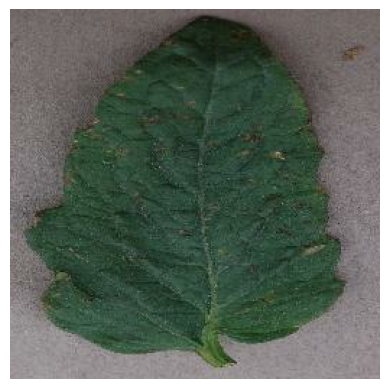

In [42]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # show first image (convert to uint8 for display)
    plt.axis("off")                                      # hide axes


### Label id → class name mapping
Prints the numeric label id for each class. **Note:** this cell previously contained extra code; it has been cleaned to only show the mapping.


In [43]:
for label_id, class_name in enumerate(dataset.class_names):
    print(f"{label_id} : {class_name}")  # print: class_index : class_name



0 : Tomato___Leaf_mold
1 : Tomato___bacterial_spot
2 : Tomato___early_blight
3 : Tomato___healthy
4 : Tomato___late_blight
5 : Tomato___mosaic_virus
6 : Tomato___septoria_leaf_spot
7 : Tomato___spider_mites_two-spotted_spider_mite
8 : Tomato___target_spot
9 : Tomato___yellow_leaf_curl_virus


### Collect one sample per class
Unbatches the dataset and stores the first image seen for each class. This is useful for later visualization.


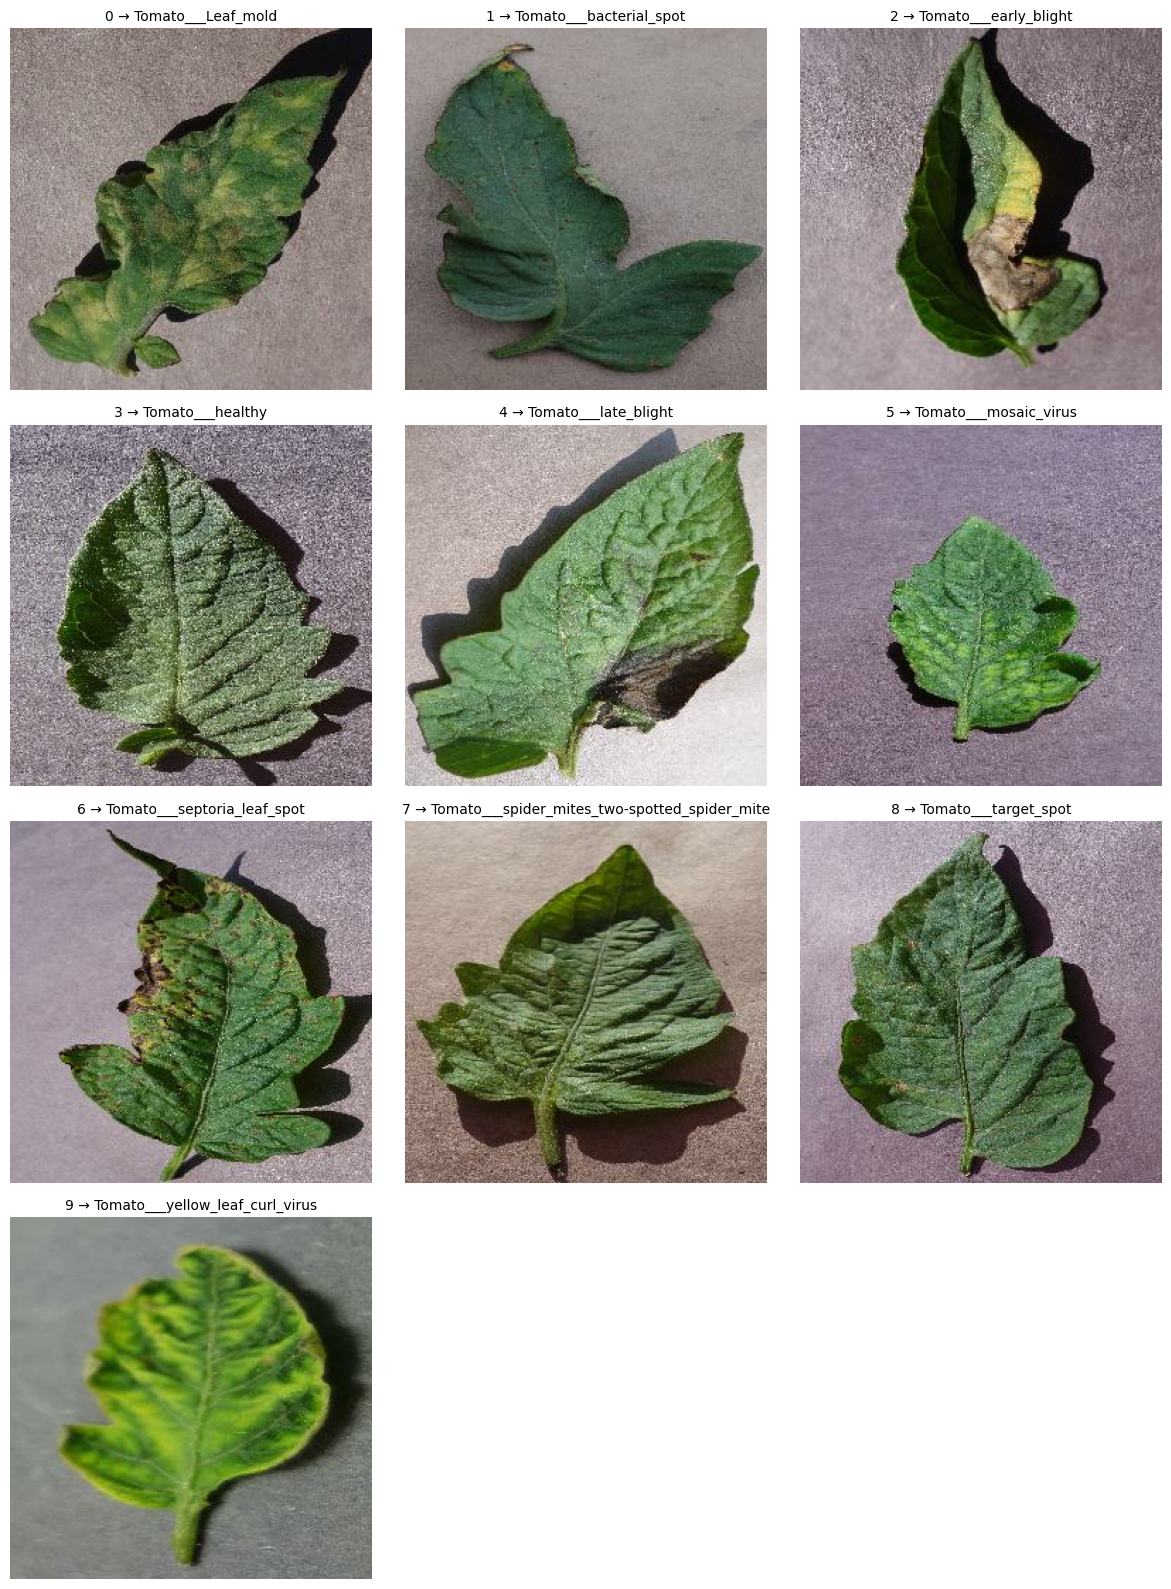

In [44]:
import math

class_names = dataset.class_names                 # class names (from folder names)
num_classes = len(class_names)                    # number of classes

samples = {}                                      # store 1 sample image per class

for img, label in dataset.unbatch():              # iterate image-by-image (not in batches)
    label_id = int(label.numpy())                 # tensor -> int
    if label_id not in samples:
        samples[label_id] = img                   # keep the first image for this class
    if len(samples) == num_classes:
        break                                     # stop after collecting all classes

cols = 3
rows = math.ceil(num_classes / cols)              # rows needed for the grid

plt.figure(figsize=(4*cols, 4*rows))
for i, label_id in enumerate(sorted(samples.keys())):
    ax = plt.subplot(rows, cols, i + 1)           # position in the grid

    img = samples[label_id].numpy().astype("uint8")  # convert to display format
    plt.imshow(img)                               # show image
    plt.title(f"{label_id} → {class_names[label_id]}", fontsize=10)  # label + name
    plt.axis("off")                               # hide axes

plt.tight_layout()                                # nicer spacing
plt.show()                                        # render the figure


## 4. Train/validation/test split
Splits a `tf.data.Dataset` into train/val/test using `take()` and `skip()`. This assumes the dataset has a known length.


In [45]:
def spliting_the_data(ds, train_split=0.80, val_split=0.10, test_split=0.10, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)                          # total number of batches/elements in ds

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) # shuffle before splitting

    train_size = int(train_split * ds_size)    # number of items for train
    val_size   = int(val_split * ds_size)      # number of items for val

    train_ds = ds.take(train_size)             # first part -> train
    val_ds   = ds.skip(train_size).take(val_size)  # next part -> val
    test_ds  = ds.skip(train_size).skip(val_size)  # remaining -> test

    return train_ds, val_ds, test_ds           # return the 3 datasets


### Create the splits
Runs the split function and produces `train_ds`, `val_ds`, and `test_ds`.


In [46]:
train_ds, val_ds, test_ds = spliting_the_data(dataset)  # split dataset into train/val/test



### Check split sizes
Shows the number of batches in each split (may be `unknown` in some pipelines).


In [47]:
len(train_ds), len(val_ds), len(test_ds)  # number of batches/items in each split

(835, 104, 105)

## 5. Preprocessing and data augmentation
- **Weight selection** to handle the classes imbalance
- **Resizing** ensures all images have the same shape.
- **Rescaling** normalizes pixels to `[0, 1]`.
- **Augmentation** introduces realistic variation (flip/rotate/zoom/shift/contrast/noise) to 
improve generalization.



In [48]:
from collections import Counter

# Count labels in TRAIN split (recommended, not full dataset)
counter = Counter()
for _, y in train_ds:
    counter.update(y.numpy().tolist())

num_classes = len(class_names)
total = sum(counter.values())

class_weight = {i: total / (num_classes * counter[i]) for i in range(num_classes)}

for i, name in enumerate(class_names):
    print(f"{i:2d}  {name:45s}  count={counter[i]:5d}  weight={class_weight[i]:.3f}")

 0  Tomato___Leaf_mold                             count=  881  weight=1.515
 1  Tomato___bacterial_spot                        count= 1858  weight=0.719
 2  Tomato___early_blight                          count=  854  weight=1.563
 3  Tomato___healthy                               count= 1325  weight=1.008
 4  Tomato___late_blight                           count= 1672  weight=0.798
 5  Tomato___mosaic_virus                          count=  340  weight=3.926
 6  Tomato___septoria_leaf_spot                    count= 1547  weight=0.863
 7  Tomato___spider_mites_two-spotted_spider_mite  count= 1339  weight=0.997
 8  Tomato___target_spot                           count= 1140  weight=1.171
 9  Tomato___yellow_leaf_curl_virus                count= 2394  weight=0.558


In [49]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),   # resize to fixed size
    layers.Rescaling(1.0/255)                  # normalize pixels to [0, 1]
], name="resize_and_rescale")

# Stronger augmentation for real-world photos (lighting/background/pose variability).
# Tip: If validation accuracy drops a lot, reduce augmentation strength (e.g., rotation/zoom).
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),  # random flips
    layers.RandomRotation(0.25),                   # rotate up to ~25% of a full turn
    layers.RandomZoom(0.15),                       # zoom in/out
    layers.RandomTranslation(0.10, 0.10),          # shift images (height, width)
    layers.RandomContrast(0.20),                   # contrast jitter
    layers.GaussianNoise(0.04),                    # small sensor noise (train-time only)
], name="data_augmentation")


## 6. Build the CNN model


### Model architecture
Defines a Sequential CNN: preprocessing → conv/pool blocks → flatten → dense → softmax. If you want a deeper network, add more conv/pool blocks.


In [50]:
input_shape = (image_size, image_size, channels)   # shape of one image (H, W, C)

class_names = dataset.class_names                  # class labels (folder names)
class_names                                      # display class names
n_classes = len(class_names)                       # number of classes

model = models.Sequential([
    resize_and_rescale,                            # resize + normalize
    data_augmentation,                             # random flips/rotations
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),  # conv block 1
    layers.MaxPooling2D((2,2)),                    # downsample

    layers.Conv2D(64, (3,3), activation='relu'),   # conv block 2
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),   # conv block 3
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),   # conv block 4
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),   # conv block 5
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),   # conv block 6
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),                              # flatten feature maps -> vector
    layers.Dense(64, activation='relu'),           # fully connected layer
    layers.Dense(n_classes, activation='softmax')  # output probabilities
])

model.build((None, image_size, image_size, channels))  # create model weights with batch dim = None
model.summary()                                        # show model layers + parameters



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resize_and_rescale (Sequen  (None, 256, 256, 3)       0         
 tial)                                                           
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                       

### Compile the model
Sets the optimizer, loss function, and metrics. `SparseCategoricalCrossentropy` is correct when labels are integer-encoded.


In [51]:
model.compile(
    optimizer='adam',   # training algorithm (Adam optimizer)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # loss for integer labels + softmax output
    metrics=['accuracy']  # track accuracy during training/eval
)

model.summary()  # show model architecture + parameters




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resize_and_rescale (Sequen  (None, 256, 256, 3)       0         
 tial)                                                           
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                       

### Early stopping 

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # training callbacks

# Ensure the models folder exists
os.makedirs("../models", exist_ok=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",              # watch validation loss
        mode="min",                      # lower is better
        patience=9,                      # stop if no improvement for 9 epochs
        restore_best_weights=True        # keep best weights found
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "../models/best_tomato_model.keras",              # file to save best model
        monitor="val_loss",
        mode="min",
        save_best_only=True              # save only when val_loss improves
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        mode="min",
        factor=0.5,                      # reduce LR by half
        patience=2,                      # wait 2 epochs without improvement
        min_lr=1e-6,                     # don't go below this LR
        verbose=1                        # print when LR changes
    )
]


### GPU setup (optional)
Enables memory growth so TensorFlow doesn't reserve all GPU memory at once.


In [53]:
import tensorflow as tf  # TensorFlow library

gpus = tf.config.list_physical_devices('GPU')          # list available GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # use GPU memory as needed (avoid full pre-allocation)

print("GPUs:", gpus)                                   # show detected GPUs



GPUs: []


### Train or load a saved model
Use `TRAIN = True` to train and save, or `TRAIN = False` to load the saved model from disk. This cell also prints TensorFlow/Keras versions and some file info.


In [55]:
import json
import os


MODEL_PATH = "../models/01_tomato_disease_model.keras"  # where to save/load the model
TRAIN = True  # True = train + save, False = load existing model

# Make sure the models folder exists BEFORE saving
Path("../models").mkdir(parents=True, exist_ok=True)

if TRAIN:
    print("Training model...")
    model_history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1
    )

    model.save(MODEL_PATH)

    # Save class names for Streamlit / inference (keeps label order consistent)
    Path("../streamlit_app/tomato/tomato_class_names.json").write_text(
        json.dumps(class_names, indent=2),
        encoding="utf-8"
    )

    # Save epoch history
    pd.DataFrame(model_history.history).to_csv(
        "../streamlit_app/tomato/training_history.csv",
        index=False
    )

    print("Saved model to:", MODEL_PATH)

else:
    if os.path.exists(MODEL_PATH):
        print("Loading saved model...")
        model = tf.keras.models.load_model(MODEL_PATH)
        print("Loaded model from:", MODEL_PATH)
    else:
        raise FileNotFoundError(
            f"Model not found at: {MODEL_PATH}\n"
            "Either fix the path or set TRAIN=True to train and save the model."
        )


Training model...
Epoch 1/40


835/835 [==============================] - 729s 761ms/step - loss: 2.1940 - accuracy: 0.1757 - val_loss: 1.9035 - val_accuracy: 0.3666 - lr: 0.0010
Epoch 2/40
835/835 [==============================] - 723s 781ms/step - loss: 1.8585 - accuracy: 0.3667 - val_loss: 1.5751 - val_accuracy: 0.4393 - lr: 0.0010
Epoch 3/40
835/835 [==============================] - 745s 810ms/step - loss: 1.6173 - accuracy: 0.4587 - val_loss: 1.3441 - val_accuracy: 0.5186 - lr: 0.0010
Epoch 4/40
835/835 [==============================] - 742s 806ms/step - loss: 1.3691 - accuracy: 0.5402 - val_loss: 1.1315 - val_accuracy: 0.6010 - lr: 0.0010
Epoch 5/40
835/835 [==============================] - 744s 806ms/step - loss: 1.1445 - accuracy: 0.6213 - val_loss: 1.0035 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 6/40
835/835 [==============================] - 739s 794ms/step - loss: 0.9668 - accuracy: 0.6825 - val_loss: 0.8548 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 7/40
835/835 [======

### Testing and model evaluation
Returns test loss and test accuracy.


In [56]:
if "scores" not in globals():
    model.evaluate(test_ds, verbose=1)
else:
    print("✅ Using cached scores (not re-evaluating).")

print("metrics:", model.metrics_names)


105/105 [==============================] - 87s 207ms/step - loss: 0.4213 - accuracy: 0.8524
metrics: ['loss', 'accuracy']


### Predict labels on the test set
Collects true labels and predicted labels so we can build a classification report and confusion matrix.


In [57]:
y_true_list = []                      # store true labels from all batches
y_pred_list = []                      # store predicted labels from all batches

for x_batch, y_batch in test_ds:      # loop over test batches (images, labels)
    probs = model.predict(x_batch, verbose=0)   # predicted class probabilities
    y_pred_batch = np.argmax(probs, axis=1)     # pick class with highest probability

    y_true_batch = y_batch.numpy()    # true labels as numpy

    y_true_list.append(y_true_batch)  # collect true labels
    y_pred_list.append(y_pred_batch)  # collect predicted labels

y_true = np.concatenate(y_true_list)  # merge all true labels into one array
y_pred = np.concatenate(y_pred_list)  # merge all predictions into one array

print("Manual test accuracy:", (y_true == y_pred).mean())  # compare with model.evaluate accuracy


Manual test accuracy: 0.8613095238095239


### Confusion matrix plot
Shows where the model confuses one class for another.


<Figure size 1000x800 with 0 Axes>

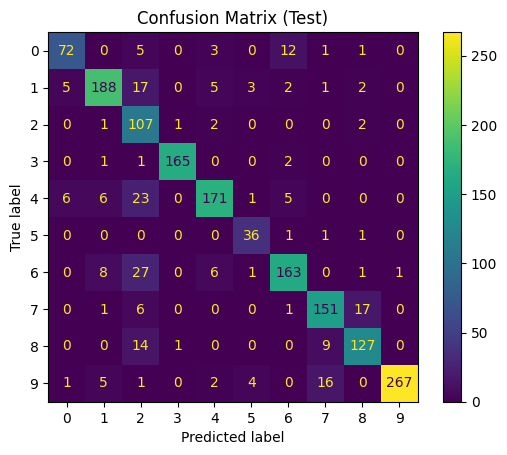

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # confusion matrix tools

cm = confusion_matrix(y_true, y_pred)      # build confusion matrix from true vs predicted labels

plt.figure(figsize=(10, 8))               # set figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # wrap matrix for plotting
disp.plot(values_format="d")              # plot counts as integers
plt.title("Confusion Matrix (Test)")      # title
plt.show()                                # display plot


### Classification report
Precision/recall/F1-score per class, plus macro and weighted averages.


In [26]:
from sklearn.metrics import classification_report
cm = confusion_matrix(y_true, y_pred)  # compute confusion matrix

print(classification_report(
    y_true, y_pred,                    # true labels vs predicted labels
    target_names=class_names,          # show class names instead of numbers
    digits=4                           # print metrics with 4 decimals
))



                                               precision    recall  f1-score   support

                           Tomato___Leaf_mold     0.9884    0.8500    0.9140       100
                      Tomato___bacterial_spot     0.9710    0.9263    0.9481       217
                        Tomato___early_blight     0.7928    0.9167    0.8502        96
                             Tomato___healthy     0.9302    1.0000    0.9639       160
                         Tomato___late_blight     0.9787    0.9020    0.9388       204
                  Tomato___septoria_leaf_spot     0.9096    0.9306    0.9200       173
Tomato___spider_mites_two-spotted_spider_mite     0.9006    0.8631    0.8815       168
                         Tomato___target_spot     0.7516    0.9603    0.8432       126
       Tomato___tomato_yellow_leaf_curl_virus     0.9942    0.9663    0.9801       534
                         Tomato__mosaic_virus     1.0000    0.9130    0.9545        46

                                     accu

### Inspect wrong predictions
Collects a few misclassified examples so you can visually check what went wrong.


In [ ]:
import matplotlib.pyplot as plt   # plotting
import numpy as np                # arrays

wrong = []  # store (image, true_label, pred_label) for mistakes

for x_batch, y_batch in test_ds:                      # loop over test batches
    probs = model.predict(x_batch, verbose=0)         # predict probabilities
    pred = np.argmax(probs, axis=1)                   # predicted class ids

    if len(y_batch.shape) > 1 and y_batch.shape[-1] > 1:  # if labels are one-hot
        true = np.argmax(y_batch.numpy(), axis=1)          # convert to class ids
    else:
        true = y_batch.numpy().astype(int)                 # sparse labels -> int

    for i in range(len(true)):                             # check each item in batch
        if true[i] != pred[i]:
            wrong.append((x_batch[i].numpy().astype("uint8"), true[i], pred[i]))  # save mistake
    if len(wrong) >= 25:
        break                                              # stop after collecting 25 mistakes

plt.figure(figsize=(12, 10))                               # create figure
for i, (img, t, p) in enumerate(wrong[:25]):               # plot up to 25 wrong images
    plt.subplot(5, 5, i+1)
    plt.imshow(img)                                       # show image
    t_name = class_names[t] if "class_names" in globals() else str(t)  # true name
    p_name = class_names[p] if "class_names" in globals() else str(p)  # pred name
    plt.title(f"T:{t_name}\nP:{p_name}", fontsize=8)       # title (T=true, P=pred)
    plt.axis("off")                                       # hide axes
plt.tight_layout()                                        # spacing
plt.show()                                                # display


### Error analysis 

In [ ]:
import numpy as np  # arrays + numerical ops

pairs = []                          # store (count, true_class_name, predicted_class_name)
n = len(class_names)                # number of classes

for i in range(n):                  # loop over true class index
    for j in range(n):              # loop over predicted class index
        if i != j and cm[i, j] > 0: # keep only mistakes (off-diagonal) with count > 0
            pairs.append((cm[i, j], class_names[i], class_names[j]))  # save this confusion pair

for c, true_name, pred_name in sorted(pairs, reverse=True)[:15]:  # top 15 biggest confusions
    print(f"{c:>3}  True: {true_name:30s}  → Pred: {pred_name}")   # print nicely formatted


The remaining errors are usually concentrated in a few **visually similar** categories.
Use the printed **top confusion pairs** above to decide what to improve next:

- Add/clean data for the confused classes
- Tune augmentation strength (too weak → overfit; too strong → underfit)
- Increase model capacity or switch to transfer learning (e.g., ResNet/MobileNet)
- Consider higher input resolution if symptoms are very small
